# Explore all scenario results

This notebook reproduces the analysis of Section 4.3.1 to Section 4.3.5 with some additional visualizations.

### Setup
Follow the instructions `README.md` to download and setup the data files.

In [1]:
evaluation_file = '../data/output/output.csv'
plot_output_path = '../plots/'

In [2]:
%matplotlib inline
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
font_scale=2.2
sns.set_context("notebook", font_scale=font_scale)
plt.rcParams['figure.figsize'] = (10,10)

In [3]:
# Set "True" to output tables in tex-style
print_latex = False

In [4]:
def num_init_labeled(x):
    if x['initial_pool_strategy'] == 'Pp':
        return 0.1 * x['num_points']
    elif x['initial_pool_strategy'] == 'Pn':
        return 20
    elif x['initial_pool_strategy'] == 'Pa':
        return x['num_dimensions'] + 5
    else:
        return 0        

In [5]:
qs_types = {
    'data': ['MinimumMarginPQs', 'ExpectedMinimumMarginPQs', 'ExpectedMaximumEntropyPQs', 'MinimumLossPQs'],
    'model': ['HighConfidencePQs', 'DecisionBoundaryPQs', 'NeighborhoodBasedPQs', 'BoundaryNeighborCombinationPQs'],
    'random': ['RandomPQs', 'RandomOutlierPQs']
}
qs_types = {y: x for x in qs_types for y in qs_types[x] }

In [6]:
def pretty_plot(title="Plot", f=sns.catplot, plot_size=(12, 5), pretty_order=None, pretty_hue_order=None, **kwargs):
    if 'hue' in kwargs:
        kwargs['hue_order'] = order[kwargs['hue']] if pretty_hue_order is None else pretty_hue_order
    if 'x' in kwargs and f != sns.scatterplot and f != sns.pointplot:
        kwargs['order'] = order[kwargs['x']] if pretty_order is None else pretty_order
    fig, ax = plt.subplots()
    _ = fig.set_size_inches(plot_size)
    g = f(ax=ax, **kwargs)
    if type(g) == sns.axisgrid.FacetGrid:
        plt.close(g.fig)
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    return fig

In [7]:
def load_csv_file(f):
    df = pd.read_csv(f)
    df.split_strategy = df.split_strategy.apply(str)
    # merge kde_errors
    df.exit_code = df.exit_code.apply(lambda x: 'kde_error' if x in ["KDEException", "PyCall.PyError"] else x)
    df.exit_code = df.exit_code.apply(lambda x: 'missing_label' if x == "MissingLabelTypeException" else x)
    df.exit_code = df.exit_code.apply(lambda x: 'missing_train_data' if x == "InexactError" else x)
    # Add learning scenario
    df['model'] = df['model'].apply(lambda x: 'SVDD' if x == 'VanillaSVDD' else x)
    df['model_type'] = df['model'].apply(lambda x: 'SSAD' if 'SSAD' in x else 'SVDD')
    df['qs_type'] = df['qs'].apply(lambda x: qs_types[x])
    df['learning_scenario'] = df[['split_strategy', 'initial_pool_strategy']].astype(str).apply(lambda x: '-'.join(x), axis=1)
    df['num_init_labeled'] = df.apply(num_init_labeled, axis=1)
    # Remove Parkinson data set because of is size of only 40 observations (not useful with 50 AL iterations)
    df = df[df['data_set'] != 'Parkinson']
    df_success = df.query('exit_code == "success"').reset_index(drop=True)
    return df, df_success

In [8]:
df_full, df_full_success = load_csv_file(evaluation_file)

Number of experiments

In [9]:
df_full.id.count()

91200

In [10]:
df_full.groupby('scenario').count()[['id']]

,id
scenario,
evaluation_part1,72000
evaluation_part1_qs,12000
evaluation_part2,7200


In [11]:
f"Total experiment run time: {str(datetime.timedelta(seconds=np.sum(df_full.total_run_time)))}."

'Total experiment run time: 482 days, 13:57:28.074515.'

Experiment exit codes.

In [12]:
df_full.groupby('exit_code')[['exit_code']].count()

,exit_code
exit_code,
ArgumentError,3000
early_abort,3246
kde_error,14456
missing_label,3800
missing_train_data,3000
success,63698


* ArgumentError: Incompatible initial pools and split strategy, e.g., Pu (all unlabeled) with Si (train on inliers) OR empty training set and rule of thumb scott (-> Gamma is Inf)
* early_abort: No more unlabeled observations left (small data sets: Hepatitis and Parkinson)
* kde_error: Covariance matrix is singular (attributes vs. observations; \approx 0 threshold;
* missing_label: incompatible initial pools and query strategy
* missing_train_data: Train on labeled inliers when label pools is all unlabeled
* success: everything worked

Specify plot order.

In [13]:
order = {
    'model_type': ['SVDD', 'SSAD'],
    'qs_type': ['data', 'model', 'random'],
    'qs': ['MinimumMarginPQs', 'ExpectedMinimumMarginPQs', 'ExpectedMaximumEntropyPQs', 'MinimumLossPQs', 'HighConfidencePQs', 'DecisionBoundaryPQs', 'NeighborhoodBasedPQs', 'BoundaryNeighborCombinationPQs', 'RandomPQs', 'RandomOutlierPQs'],
    'data_set': ["ALOI", "Annthyroid", "Arrhythmia", "Cardiotocography", "Glass",
             "HeartDisease", "Hepatitis", "Ionosphere", "KDDCup99", "Lymphography",
             "PageBlocks", "Parkinson", "PenDigits", "Pima", "Shuttle", "SpamBase",
             "Stamps", "WBC", "WDBC", "WPBC", "Waveform"],
    'model': ['SVDD', 'SVDDneg', 'SSAD_0.1', 'SSAD_0.5', 'SSAD_1.0'],
    'split_strategy': ['Sh', 'Sf', 'Si'],
    'initial_pool_strategy': ['Pu', 'Pp', 'Pn', 'Pa']
}
pretty_names = {
                'AEQ': {'m_average_end_quality': 'MCC', 'c_average_end_quality': 'kappa', 'auc_average_end_quality': 'AUC', 'pauc_average_end_quality': 'PAUC'},
                'AEQ-M': {'m_average_end_quality': 'MCC-AEQ', 'c_average_end_quality': 'kappa-AEQ', 'auc_average_end_quality': 'AUC-AEQ', 'pauc_average_end_quality': 'PAUC-AEQ'},
                'SQ-M': {'m_start_quality': 'MCC-SQ', 'k_start_quality': 'kappa-SQ', 'auc_start_quality': 'AUC-SQ', 'pauc_start_quality': 'PAUC-SQ'},
                'MCC': {'m_start_quality': 'SQ', 'm_end_quality': 'EQ', 'm_average_end_quality': 'AEQ', 'm_ramp_up': 'RU'},
                'qs': {
                    'MinimumMarginQs': '$\tau_\text{MM}$',
                    'ExpectedMinimumMarginQs': '$\tau_\text{EMM}$',
                    'ExpectedMaximumEntropyQs': '$\tau_\text{EME}$',
                    'MinimumLossQs': '$\tau_\text{ML}$',
                    'HighConfidenceQs': '$\tau_\text{HC}$',
                    'DecisionBoundaryQs': '$\tau_\text{DB}$',
                    'NeighborhoodBasedQs': '$\tau_\text{NB}$',
                    'BoundaryNeighborCombinationQs': '$\tau_\text{BNC}$',
                    'RandomQs': '$\tau_\text{rand}$',
                    'RandomOutlierQs': '$\tau_\text{rand-out}$',
                  },
}

## Analysis

In [14]:
df_p1, df_p1_success = df_full.query('scenario == "evaluation_part1"'), df_full_success.query('scenario == "evaluation_part1"')

Data set statistics

In [15]:
res = df_full.groupby(["data_set"]).max()[["num_points", "num_dimensions"]].reset_index()
print(res.to_latex(index=False)) if print_latex else res

,data_set,num_points,num_dimensions
0,ALOI,1000,27
1,Annthyroid,1000,21
2,Arrhythmia,240,259
3,Cardiotocography,1000,21
4,Glass,180,7
5,HeartDisease,140,13
6,Hepatitis,60,19
7,Ionosphere,237,32
8,KDDCup99,1000,40
9,Lymphography,120,3


### Comparison of Evaluation Metrics (Section 4.3.1)

In [16]:
res = df_p1_success[["m_average_end_quality", "c_average_end_quality", "auc_average_end_quality", "pauc_average_end_quality"]].rename(columns=pretty_names['AEQ']).corr('pearson').round(2)
print(res.to_latex()) if print_latex else res

,MCC,kappa,AUC,PAUC
MCC,1.00,0.98,0.63,0.78
kappa,0.98,1.00,0.59,0.76
AUC,0.63,0.59,1.00,0.73
PAUC,0.78,0.76,0.73,1.00


Inspect correlation of mcc and pauc.

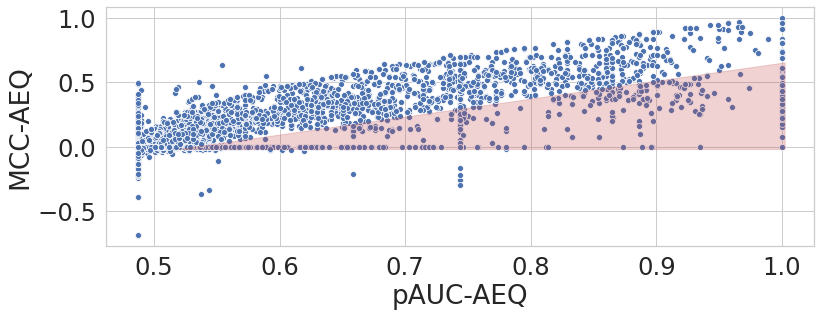

In [17]:
f = pretty_plot(title=f'PAUC vs. MCC', 
                x="pauc_average_end_quality", 
                y="m_average_end_quality", 
                data=df_p1_success.sample(5000, random_state=0),
                f = sns.scatterplot,
                legend = None)
f.axes[0].set_xlabel("pAUC-AEQ")
f.axes[0].set_ylabel("MCC-AEQ")
f.tight_layout()
t1 = plt.Polygon([[0.52, -0.02], [1.0025, 0.65], [1.0025, -0.02]], alpha=0.25, color=sns.color_palette()[3], joinstyle='round')
plt.gca().add_patch(t1)
f.savefig(f'{plot_output_path}/eval_comp_pauc_vs_mcc_5k.pdf')


### Influence of Kernel Parameter (Section 4.3.2)

Inspect the average end quality per gamma initalization strategy.

In [18]:
res = df_p1_success. \
    groupby(["model", "init_strategy_gamma"]).\
    median()[["m_start_quality", "m_average_end_quality"]].\
    rename(columns=pretty_names['MCC']).\
    reset_index().\
    round(2).\
    pivot(index = 'model', columns='init_strategy_gamma', values=['SQ', 'AEQ']) .\
    reset_index()
res = res.loc[[3, 4, 0, 1, 2], :]
print(res.to_latex(index=False)) if print_latex else res

model    SQ           AEQ        
init_strategy_gamma           Scott WangTax Scott WangTax
3                        SVDD  0.06    0.06  0.09    0.10
4                     SVDDneg  0.09    0.14  0.21    0.31
0                    SSAD_0.1  0.07    0.11  0.15    0.24
1                    SSAD_0.5  0.06    0.06  0.12    0.22
2                    SSAD_1.0  0.04    0.08  0.10    0.15

Inspect results per data set.

In [19]:
res = df_p1_success.query('init_strategy_gamma_fitted_value != "nan" and init_strategy_gamma_fitted_value != "inf" and model == "SVDDneg"'). \
    groupby(["data_set", "init_strategy_gamma"]).\
    median()[["m_start_quality", "m_average_end_quality"]].\
    rename(columns=pretty_names['MCC']).\
    reset_index().\
    round(2).\
    pivot(index = 'data_set', columns='init_strategy_gamma', values=['SQ', 'AEQ'])
print(res.to_latex(index=False)) if print_latex else res

SQ           AEQ        
init_strategy_gamma Scott WangTax Scott WangTax
data_set                                       
ALOI                 0.03    0.03  0.03    0.09
Annthyroid          -0.02    0.00 -0.02    0.04
Arrhythmia           0.05    0.19  0.15    0.32
Cardiotocography     0.25    0.15  0.30    0.20
Glass                0.06    0.22  0.06    0.45
HeartDisease         0.21    0.34  0.30    0.37
Hepatitis            0.08    0.00  1.00    0.57
Ionosphere           0.28    0.31  0.43    0.43
KDDCup99             0.45    0.31  0.61    0.49
Lymphography         0.27    0.27  0.55    0.55
PageBlocks           0.40    0.34  0.50    0.41
PenDigits            0.00    0.00  0.10    0.10
Pima                 0.03    0.07  0.04    0.17
Shuttle              0.00    0.10  0.11    0.38
SpamBase             0.04    0.12  0.07    0.14
Stamps               0.08    0.12  0.18    0.19
WBC                  0.37    0.35  0.54    0.46
WDBC                 0.27    0.28  0.55    0.54
WPBC                 0.00    0.00  0.12    0.12
Waveform             0.01    0.04  0.02    0.13

Inspect fitted gamma values

In [20]:
df_p1_success.query('init_strategy_gamma_fitted_value != "nan" and init_strategy_gamma_fitted_value != "inf"'). \
   groupby(["init_strategy_gamma"]).\
   agg({"init_strategy_gamma_fitted_value": [min, np.median, np.mean, max]})

init_strategy_gamma_fitted_value                      \
                                                 min    median      mean   
init_strategy_gamma                                                        
Scott                                       0.504631  0.765379  0.766461   
WangTax                                     0.062500  4.000000  5.899945   

                                
                           max  
init_strategy_gamma             
Scott                 0.988149  
WangTax              16.000000

Only include results for WangTax in the next sections

In [21]:
df_p1_wang_success = df_p1_success.query('init_strategy_gamma == "WangTax"')

### Comparison of Split Strategies (Section 4.3.3)

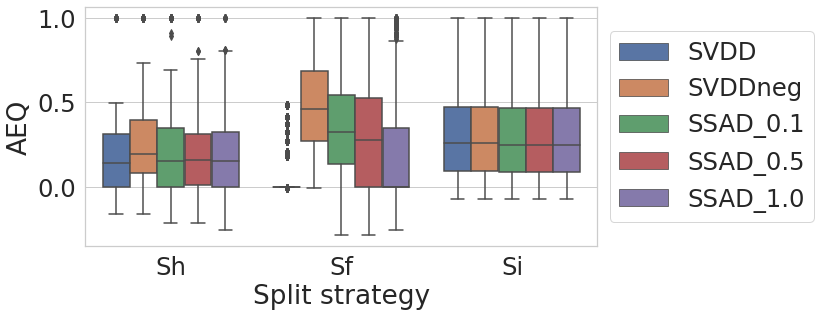

In [22]:
f = pretty_plot(title=f'Comparison of split strategies', 
                x="split_strategy", 
                y="m_average_end_quality", 
                hue="model",
                data=df_p1_wang_success,
                kind="box")
f.axes[0].set_xlabel('Split strategy');
f.axes[0].set_ylabel('AEQ')
f.tight_layout()
f.savefig(f'{plot_output_path}/eval_comp_split_strategies.pdf')

Visualize fluctuation with Average Quality Gain and Average Quality Loss by model.

Text(0, 0.5, 'AQG')

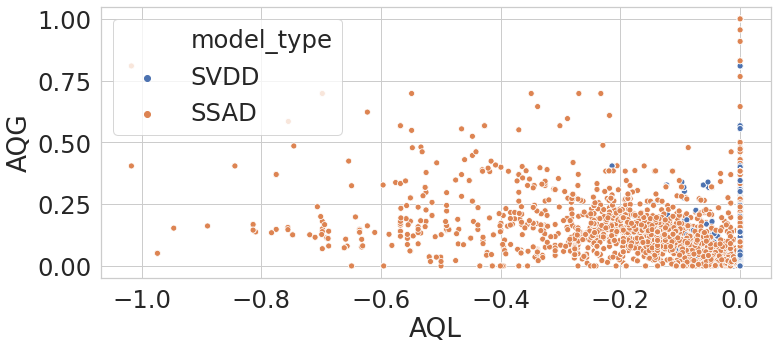

In [23]:
f = pretty_plot(title=f'Comparison of initial pool strategies', 
            x="m_average_loss", 
            y="m_average_gain", 
            hue="model_type", 
            data=df_p1_wang_success.query('split_strategy == "Sf"'), 
            f=sns.scatterplot)
f.axes[0].set_xlabel('AQL')
f.axes[0].set_ylabel('AQG')

### Comparison of Initial Pool Strategies (Section 4.3.4)

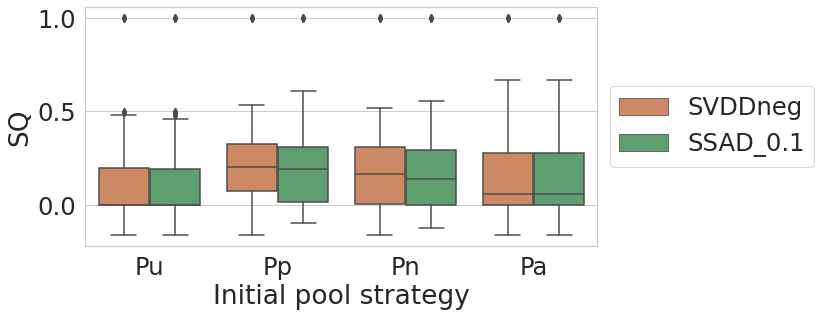

In [24]:
f = pretty_plot(title=f'Comparison of initial pool strategies', 
            x="initial_pool_strategy", 
            y="m_start_quality", 
            hue="model", 
            data=df_p1_wang_success, 
            kind="box",
            pretty_order=['Pu', 'Pp', 'Pn', 'Pa'],
            pretty_hue_order=['SVDDneg', 'SSAD_0.1'],
            palette=sns.color_palette()[1:])
f.axes[0].set_xlabel('Initial pool strategy')
f.axes[0].set_ylabel('SQ')
f.tight_layout()
f.savefig(f'{plot_output_path}/eval_comp_initial_pool_strategies.pdf')

Inspect the high value outliers from the plot.

In [25]:
df_p1_wang_success.query('m_start_quality > 0.8').groupby('data_set').count()

,scenario,id,file_name,split_strategy,initial_pool_strategy,initial_pool_resample_version,initial_pool_num_labeled,model,init_strategy_C,init_strategy_gamma,...,pauc_aulc,pauc_reyes_paulc,pauc_reyes_naulc,pauc_reyes_tpr,pauc_reyes_tnr,pauc_reyes_tp,model_type,qs_type,learning_scenario,num_init_labeled
data_set,,,,,,,,,,,,,,,,,,,,,
HeartDisease,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
Lymphography,102,102,102,102,102,102,102,102,102,102,...,102,102,102,102,102,102,102,102,102,102


Compare number of initially labeled observations for Pn and Pp.

In [26]:
res = df_p1_wang_success.query('data_set in ["ALOI", "WBC"] ' +
                       'and split_strategy in ["Sf"] ' +
                       'and model == "SVDDneg" ' +
                       'and initial_pool_strategy in ["Pp", "Pn"]').\
    groupby(["data_set", "initial_pool_strategy"]).\
    mean()[["num_points", "num_init_labeled", "m_start_quality", "m_average_end_quality"]].\
    rename(columns=pretty_names['MCC']).\
    reset_index().\
    round(2)
res.num_points = res.num_points.round().astype(int)
res.num_init_labeled = res.num_init_labeled.round().astype(int)
res.columns = ['Data set', 'Initial setup', 'Observations', 'Initially labeled', 'SQ', 'AEQ']
print(res.to_latex(index=False)) if print_latex else res

,Data set,Initial setup,Observations,Initially labeled,SQ,AEQ
0,ALOI,Pn,1000,20,0.00,0.14
1,ALOI,Pp,1000,100,0.17,0.22
2,WBC,Pn,200,20,0.31,0.74
3,WBC,Pp,200,20,0.31,0.72


### Comparison of query strategies (Section 4.3.5)

Load experiments with 5 resamples of the initial pool.

In [27]:
df_p1_qs_success = df_full_success.query('scenario == "evaluation_part1_qs" '+
                                         'and init_strategy_gamma == "WangTax"')

Heptatitis is not part of this evaluation section because of its size of only 60.

In [28]:
set(df_full.data_set.unique()) - set(df_p1_qs_success.data_set.unique())

{'Hepatitis'}

Compute correlation between summary statistics.

In [29]:
target_metrics = ['m_end_quality', 'm_ramp_up', 'm_quality_range',
       'm_average_end_quality', 'm_average_quality_change', 'm_average_gain',
       'm_average_loss', 'm_learning_stability', 'm_ratio_of_outlier_queries']

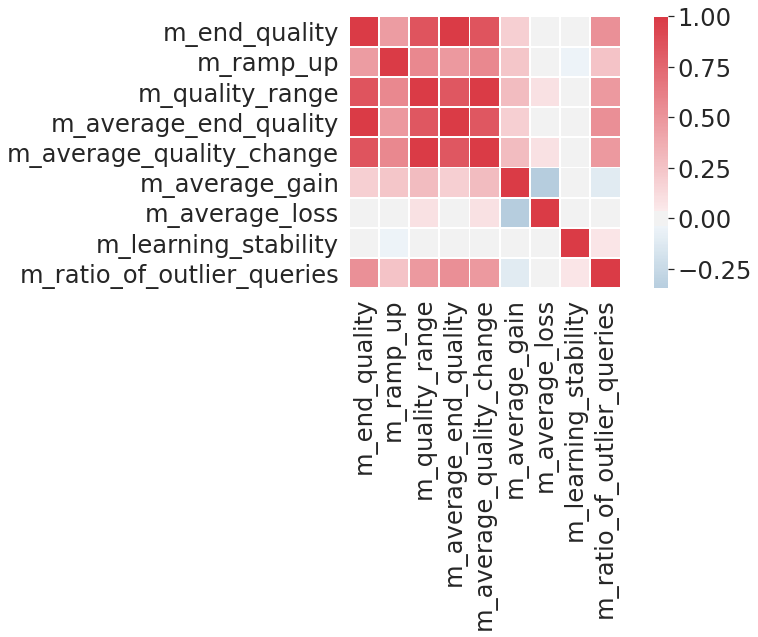

In [30]:
corr = df_p1_qs_success[target_metrics]
corr = corr.corr()
cmap = sns.diverging_palette(240, 10, as_cmap=True)
_ = pretty_plot('Correlation Qs', f=sns.heatmap, data=corr, center=0, square=True, cmap=cmap, linewidths=1)

In [31]:
# For other metrics replace this value, e.g., with "m_average_end_quality"
metric = "m_start_quality"
res = df_p1_qs_success.groupby(["data_set", "qs"]).median()[[metric]].reset_index().pivot(index='data_set', columns = 'qs')[[metric]]
res = res.T.reset_index(level=0, drop=True).T
res = res[[x for x in order['qs'] if x in res.columns]].round(decimals=4)
if print_latex:
    res.columns = [pretty_names['qs'][x] for x in res.columns]
res = res.reset_index()
res.columns = ['Data set'] + res.columns[1:].values.tolist()
print(res.to_latex(escape=False, na_rep='-', index=False)) if print_latex else res

,Data set,MinimumMarginPQs,ExpectedMinimumMarginPQs,ExpectedMaximumEntropyPQs,MinimumLossPQs,HighConfidencePQs,DecisionBoundaryPQs,NeighborhoodBasedPQs,BoundaryNeighborCombinationPQs,RandomPQs,RandomOutlierPQs
0,ALOI,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,Annthyroid,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,Arrhythmia,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,Cardiotocography,NaN,NaN,NaN,NaN,0.1379,0.1379,0.1379,0.1379,0.1379,0.1379
4,Glass,0.3258,0.3258,0.3258,0.3258,0.3258,0.3258,0.3258,0.3258,0.3258,0.3258
5,HeartDisease,0.3697,0.3697,0.3697,0.3697,0.3697,0.3697,0.3697,0.3697,0.3697,0.3697
6,Ionosphere,NaN,NaN,NaN,NaN,0.2819,0.2819,0.2819,0.2819,0.2819,0.2819
7,KDDCup99,NaN,NaN,NaN,NaN,0.1379,0.1379,0.1379,0.1379,0.1379,0.1379
8,Lymphography,0.0000,0.0000,0.0000,-0.0105,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,PageBlocks,0.4348,0.4348,0.4348,0.4348,0.4348,0.4348,0.4348,0.4348,0.4348,0.4348


##### Additional statistics

Comparison against upper bound (classifier trained with all ground-truth labels).

In [32]:
df_sq = df_p1_qs_success.query('qs == "RandomPQs" and init_strategy_gamma == "WangTax" and model == "SVDDneg"')[['file_name', 'initial_pool_resample_version', 'm_start_quality']].reset_index(drop=True)
df_sq.columns = ['data_file', 'seed', 'mcc_sq']

In [33]:
df_baseline_svddneg = pd.read_csv('../data/output/svddneg_baseline.csv')
df_baseline_svddneg['model'] = "SVDDneg"
df_baseline_ssad = pd.read_csv('../data/output/ssad_baseline.csv')
df_baseline_ssad['model'] = "SSAD"
df_baselines = pd.concat([df_baseline_svddneg, df_baseline_ssad]).set_index(['data_file', 'seed'])
df_baselines = df_baselines.join(df_sq.set_index(['data_file', 'seed'])).reset_index()
df_baselines['mcc_qr'] = df_baselines['mcc'] - df_baselines['mcc_sq']
df_baselines.groupby(['data_set']).median()[['mcc_sq', 'mcc', 'mcc_qr']].round(2)

,mcc_sq,mcc,mcc_qr
data_set,,,
ALOI,0.00,0.17,0.10
Annthyroid,0.00,0.29,0.22
Arrhythmia,0.00,0.91,0.81
Cardiotocography,0.14,0.41,0.34
Glass,0.33,1.00,0.67
HeartDisease,0.37,0.96,0.63
Hepatitis,NaN,0.57,NaN
Ionosphere,0.28,1.00,0.72
KDDCup99,0.14,0.90,0.77


Query selection time.

In [34]:
df_p1_qs_success.query('data_set == "PageBlocks"').groupby(['data_set', 'qs']).mean()[['time_qs_mean']]

time_qs_mean
data_set   qs                                          
PageBlocks BoundaryNeighborCombinationPQs      0.403664
           DecisionBoundaryPQs                 0.473667
           ExpectedMaximumEntropyPQs           0.016654
           ExpectedMinimumMarginPQs            0.022336
           HighConfidencePQs                   0.478204
           MinimumLossPQs                    111.871537
           MinimumMarginPQs                    0.019916
           NeighborhoodBasedPQs                0.501444
           RandomOutlierPQs                    0.471700
           RandomPQs                           0.000472

Inspect the ratio of outliers queried per model and query startegy.

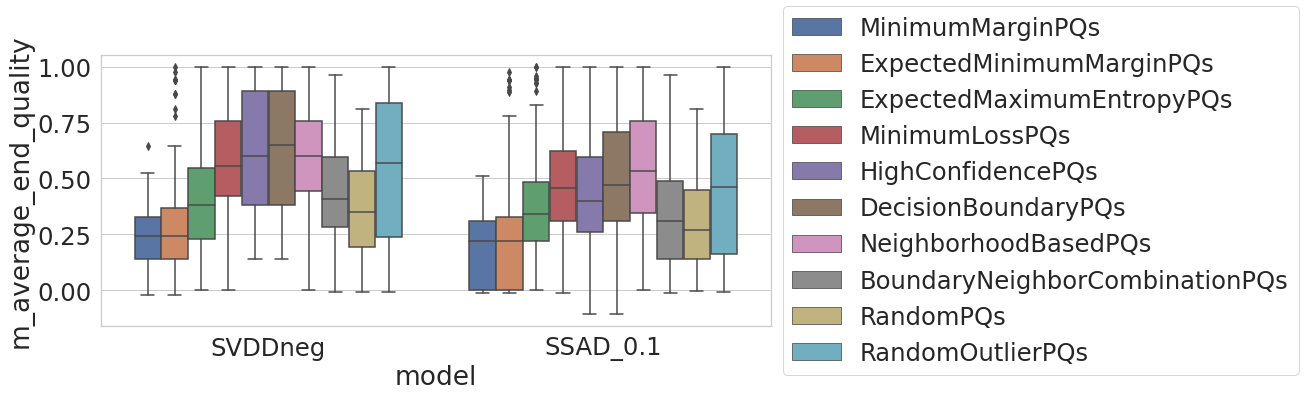

In [35]:
f = pretty_plot(title=f'Init strategy vs ratio of outliers', 
                x="model", 
                y="m_average_end_quality",
                hue="qs",
                data=df_p1_qs_success,
                pretty_order=['SVDDneg', 'SSAD_0.1'],
                kind="box")

Inspect the performance of the two gamma initialization strategies per query strategy for SVDDneg.

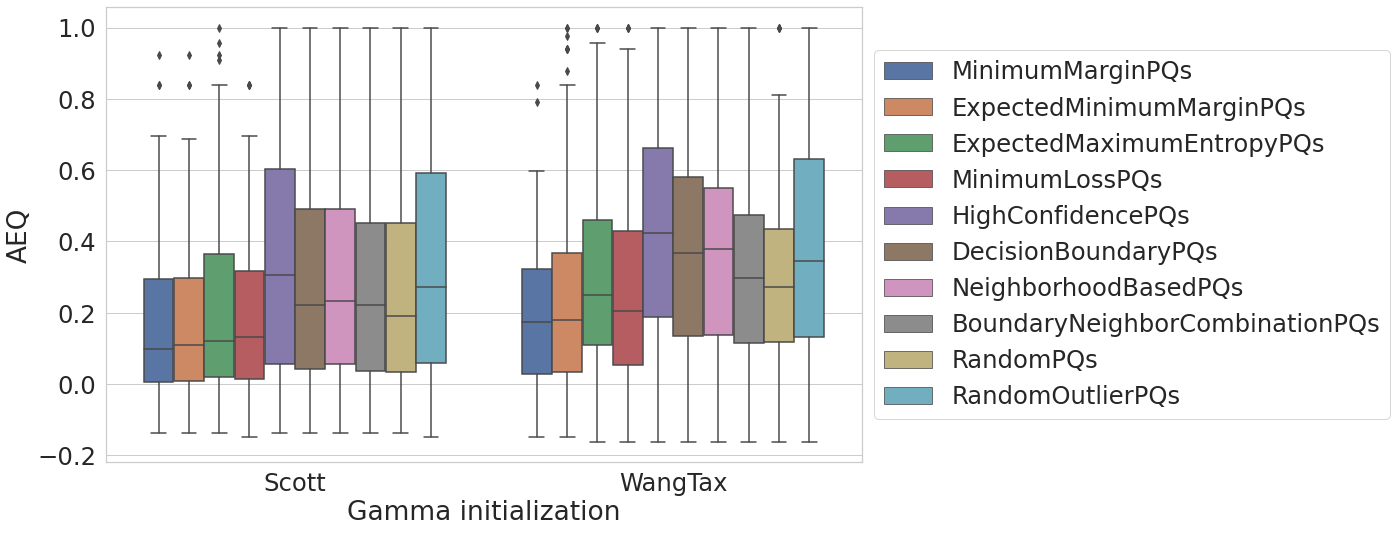

In [36]:
f = pretty_plot(title=f'Init strategy vs ratio of outliers', 
                x="init_strategy_gamma",
                y="m_average_end_quality",
                hue="qs",
                data=df_p1_success.query('model == "SVDDneg"'),
                pretty_order=['Scott', 'WangTax'],
                kind="box",
                plot_size=(20, 8))
f.axes[0].set_xlabel('Gamma initialization')
f.axes[0].set_ylabel('AEQ')
f.tight_layout()

### Reyes summary stats comparison.

Active learning metrics proposed in: Reyes, O. et al. 2018. Statistical comparisons of active learning strategies over multiple datasets. Knowledge-Based Systems. 145, (2018), 1–14. DOI:https://doi.org/10.1016/j.knosys.2018.01.033.

In [37]:
df_p1_qs_success.query('data_set == "WBC"')[['data_set', 'qs', 'm_quality_range', 'm_aulc', 'm_reyes_paulc', 'm_reyes_tpr', 'm_reyes_naulc', 'm_reyes_tnr', 'm_reyes_tp']].groupby('qs').mean()

,m_quality_range,m_aulc,m_reyes_paulc,m_reyes_tpr,m_reyes_naulc,m_reyes_tnr,m_reyes_tp
qs,,,,,,,
BoundaryNeighborCombinationPQs,0.114156,15.631715,0.673538,0.288013,14.958177,-0.173856,2.658762
DecisionBoundaryPQs,0.627494,43.083536,6.488007,0.835550,36.595529,-0.208056,13.165330
ExpectedMaximumEntropyPQs,0.502567,26.443031,4.119722,0.597854,22.323309,-0.095287,4.742646
ExpectedMinimumMarginPQs,-0.015909,14.980096,0.193565,0.140425,14.786532,-0.156334,2.098706
HighConfidencePQs,0.531359,30.548613,5.332749,0.891977,25.215864,-0.360619,10.129997
MinimumLossPQs,0.691006,30.504372,6.555052,0.851674,23.949320,-0.160668,9.545914
MinimumMarginPQs,0.000000,15.262760,0.213276,0.140626,15.049484,-0.140626,2.078002
NeighborhoodBasedPQs,0.413184,28.241393,2.509605,0.489741,25.731788,-0.076557,2.823244
RandomOutlierPQs,0.691006,47.105837,6.942816,0.774909,40.163021,-0.083903,8.661994


When TNR is negative there is a drop in the active learning curve. Yet, a negative TNR increases the total TP score according to the equation.